In [1]:
# %cd /notebooks/kaggle-garbage-classification
# !source .env3/bin/activate
# !pip install -U fastai
# !pip install -U fastcore

In [1]:
import torch
print(torch.__version__)  # Versão do PyTorch
print(torch.version.cuda)  # Versão do CUDA

2.5.1+cu118
11.8


In [25]:
from fastcore.xtras import Path
from fastai.vision.all import *
from PIL import Image
from fastai.data.core import Datasets

from fastai.callback.tracker import SaveModelCallback

from sklearn.model_selection import StratifiedKFold

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
root_path = Path("/notebooks/kaggle-garbage-classification")
data_path = Path(root_path/"data")
data_path.ls()

(#7) [Path('/notebooks/kaggle-garbage-classification/data/metal'),Path('/notebooks/kaggle-garbage-classification/data/trash'),Path('/notebooks/kaggle-garbage-classification/data/glass'),Path('/notebooks/kaggle-garbage-classification/data/cardboard'),Path('/notebooks/kaggle-garbage-classification/data/paper'),Path('/notebooks/kaggle-garbage-classification/data/plastic'),Path('/notebooks/kaggle-garbage-classification/data/.ipynb_checkpoints')]

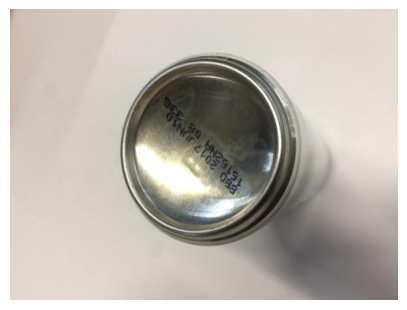

In [8]:
im_path = (data_path/'metal').ls()[0]
im = PILImage.create(im_path)
im.show();

In [10]:
bad_imgs = []
vocab = ['metal', 'trash', 'glass', 'cardboard', 'paper', 'plastic']
for c in vocab:
    for im in (data_path/c).ls():
        try:
            _ = Image.open(im)
        except:
            bad_imgs.append(im)
            im.unlink()
bad_imgs, len(bad_imgs)

([], 0)

## Criando os labels

In [11]:
fnames = get_image_files(data_path)
fnames

(#2527) [Path('/notebooks/kaggle-garbage-classification/data/metal/metal145.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal344.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal66.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal204.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal293.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal282.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal303.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal308.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal57.jpg'),Path('/notebooks/kaggle-garbage-classification/data/metal/metal128.jpg')...]

In [12]:
# Vamos separar em treino e teste
random.shuffle(fnames)

train_fnames = [filename for filename in fnames[:int(len(fnames) * .9)]]
test_fnames = [filename for filename in fnames[int(len(fnames) * .9):]]

In [19]:
vocab = list(set(map(parent_label, train_fnames)))
# vocab = list(map(parent_label, train_fnames))
vocab

['glass', 'cardboard', 'metal', 'trash', 'plastic', 'paper']

-----------------------------------------------------m

In [20]:
pipe = Pipeline([parent_label,Categorize(vocab=vocab)])
labels = list(map(pipe,train_fnames))
labels

[TensorCategory(1),
 TensorCategory(3),
 TensorCategory(4),
 TensorCategory(1),
 TensorCategory(4),
 TensorCategory(0),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(5),
 TensorCategory(1),
 TensorCategory(1),
 TensorCategory(5),
 TensorCategory(0),
 TensorCategory(3),
 TensorCategory(4),
 TensorCategory(4),
 TensorCategory(1),
 TensorCategory(1),
 TensorCategory(0),
 TensorCategory(2),
 TensorCategory(0),
 TensorCategory(3),
 TensorCategory(0),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(4),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(0),
 TensorCategory(0),
 TensorCategory(3),
 TensorCategory(4),
 TensorCategory(3),
 TensorCategory(4),
 TensorCategory(5),
 TensorCategory(4),
 TensorCategory(1),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(3),
 TensorCategory(5),
 TensorCategory(4),
 TensorCategory(1),
 TensorCategory(3),
 TensorCategory(4),
 TensorCategory(2),


## Criando os splits de validação cruzada

In [40]:
# Vamos criar os splits
splits = []
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for _, valid_indexes in skf.split(np.zeros(len(labels)), labels):
    split = IndexSplitter(valid_indexes)
    splits.append(split)

## Loop de treinamento

In [43]:
def train(train_fnames:list,splitter:IndexSplitter,valid_pcts:list=[],test_preds:list=[]):
    "Trains a single model over a set of splits based on `splitter`"
    "Trains a single model over a set of splits based on `splitter`"
    dsets = Datasets(
        train_fnames,
        tfms=[
            [PILImage.create],
            [parent_label,
            Categorize(vocab=vocab)]
            ],
        splits=splitter(train_fnames)
    )
    dls = dsets.dataloaders(
        after_item=[ToTensor(), RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))],
        after_batch=[IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)],
        bs=64,
        device=device
    )
    # learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.95)], path=root_path)
    learn = vision_learner(dls, resnet34, metrics=error_rate, path=root_path)
    
    
    # learn.fine_tune(
    #     50,  # Número máximo de épocas
    #     base_lr=3e-3,
    #     cbs=[            
    #         EarlyStoppingCallback(monitor='valid_loss', patience=5)  # Early stopping opcional
    #     ]
    # )
    
    learn.fine_tune(3,base_lr=3e-3)
    
    learn.loss_func.thresh = 0.95
    valid_pcts.append(learn.validate()[1])
    dl = learn.dls.test_dl(test_fnames)
    preds, _ = learn.get_preds(dl=dl)
    test_preds.append(preds)
    
    return valid_pcts, test_preds

In [44]:
valid_pcts = []
test_preds = []

for splitter in splits:
    valid_pcts, test_preds = train(train_fnames,splitter, valid_pcts, test_preds)

epoch,train_loss,valid_loss,error_rate,time
0,1.602485,0.614153,0.191209,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.648905,0.538892,0.158242,00:11
1,0.452481,0.356841,0.116484,00:11
2,0.288276,0.305536,0.101099,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.590758,0.674098,0.202198,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.633904,0.618916,0.195604,00:12
1,0.419236,0.392498,0.123077,00:12
2,0.275445,0.346512,0.116484,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.721651,0.689293,0.204396,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.618775,0.617445,0.184615,00:11
1,0.421190,0.482041,0.140659,00:11
2,0.277190,0.416332,0.120879,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.653960,0.711656,0.219780,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.716628,0.480083,0.160440,00:12
1,0.486973,0.405475,0.120879,00:12
2,0.311665,0.402371,0.120879,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.664923,0.515685,0.169604,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.652866,0.482949,0.143172,00:12
1,0.478841,0.296443,0.074890,00:12
2,0.319396,0.277805,0.077093,00:12


## Ensemble

In [45]:
test_labels = torch.stack([pipe(fname) for fname in test_fnames])
accuracy(test_preds[4], test_labels)

TensorBase(0.8854)

In [46]:
for preds in test_preds:
    print(accuracy(preds, test_labels))

TensorBase(0.8893)
TensorBase(0.8933)
TensorBase(0.8814)
TensorBase(0.9130)
TensorBase(0.8854)


In [47]:
votes = torch.stack(test_preds, dim=-1).sum(-1) / n_splits
accuracy(votes, test_labels)

TensorBase(0.9249)

NameError: name 'learn' is not defined

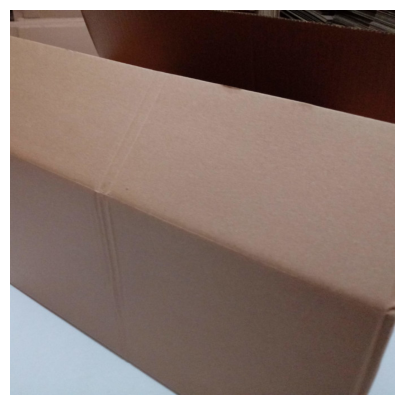

In [48]:
im_path = Path(root_path/'caixa-papelao-grande-50-c-x-26-l-x-26-a-kit-20-unidades-caixa-papelao-correio.jpg')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)

In [33]:
learn.predict(im_path)

((#1) ['cardboard'],
 tensor([False, False, False,  True, False, False]),
 tensor([1.5774e-02, 3.6381e-03, 7.1919e-03, 1.0000e+00, 3.0124e-04, 6.5152e-03]))

NameError: name 'learn' is not defined

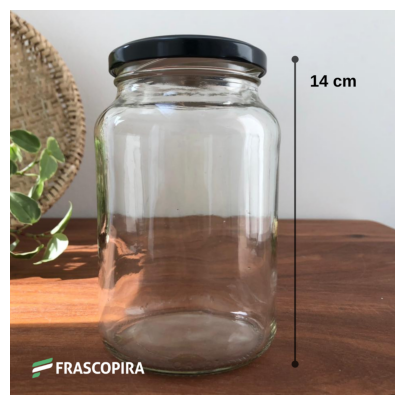

In [49]:
im_path = Path(root_path/'pote_vidro_500g_com_tampa_74_mm_preta.png')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)

((#0) [],
 tensor([False, False, False, False, False, False]),
 tensor([0.0167, 0.0630, 0.0241, 0.0066, 0.0051, 0.3667]))

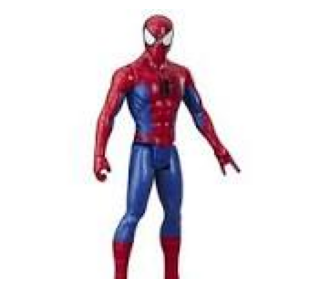

In [35]:
im_path = Path(root_path/'homem-aranha.jpeg')
im = Image.open(im_path)
show_image(im); learn.predict(im_path)